<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/DCGAN_with_load_and_save_model_ver4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
    plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

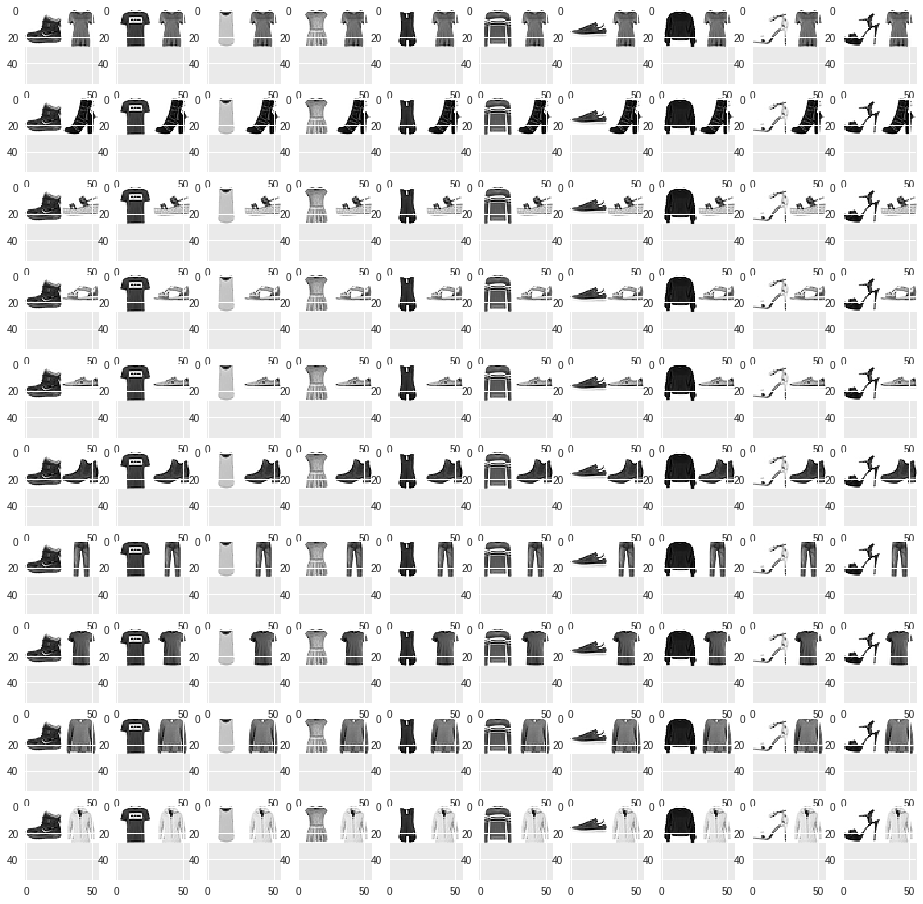

(60000, 28, 28)
(10000, 56, 56)


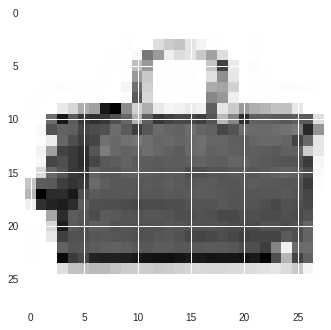

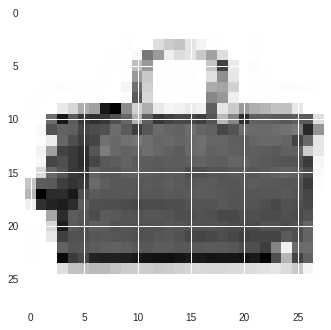

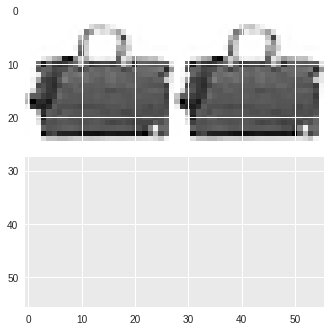

array([[[[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        ...,

        [[-0.6862745],
         [-0.6862745],
         [-0.6862745],
         ...,
         [-0.6862745],
         [-0.6862745],
         [-0.6862745]],

        [[-0.6862745],
         [-0.6862745],
         [-0.6862745],
         ...,
         [-0.6862745],
         [-0.6862745],
         [-0.6862745]],

        [[-0.6862745],
         [-0.6862745],
         [-0.6862745],
         ...,
         [-0.6862745],
         [-0.6862745],
         [-0.6862745]]],


       [[[-1.       ],
         [-1.       ],
         [-1. 

In [5]:
load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0]/10
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=1, batch_size=32, save_interval=1)
    
    
    generator.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')
    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/187 [D loss: 0.760641, acc.: 56.25%] [G loss: 0.725058]


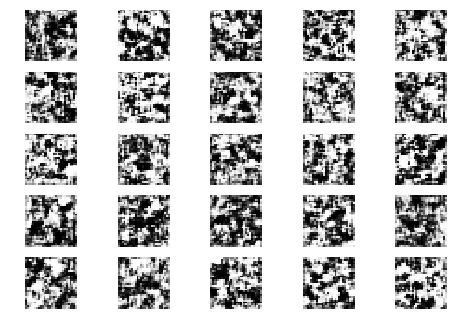

Epoch 0 Batch 1/187 [D loss: 0.736724, acc.: 62.50%] [G loss: 0.738936]
Epoch 0 Batch 2/187 [D loss: 0.569245, acc.: 71.88%] [G loss: 0.841675]
Epoch 0 Batch 3/187 [D loss: 0.524918, acc.: 75.00%] [G loss: 0.932232]
Epoch 0 Batch 4/187 [D loss: 0.505688, acc.: 78.12%] [G loss: 1.231057]
Epoch 0 Batch 5/187 [D loss: 0.404999, acc.: 81.25%] [G loss: 1.285830]
Epoch 0 Batch 6/187 [D loss: 0.392172, acc.: 84.38%] [G loss: 1.270566]
Epoch 0 Batch 7/187 [D loss: 0.271524, acc.: 93.75%] [G loss: 1.452548]
Epoch 0 Batch 8/187 [D loss: 0.272842, acc.: 93.75%] [G loss: 1.686075]
Epoch 0 Batch 9/187 [D loss: 0.302218, acc.: 87.50%] [G loss: 1.804120]
Epoch 0 Batch 10/187 [D loss: 0.259314, acc.: 93.75%] [G loss: 1.734566]
Epoch 0 Batch 11/187 [D loss: 0.243408, acc.: 90.62%] [G loss: 1.758786]
Epoch 0 Batch 12/187 [D loss: 0.198371, acc.: 93.75%] [G loss: 1.893711]
Epoch 0 Batch 13/187 [D loss: 0.283534, acc.: 93.75%] [G loss: 1.766688]
Epoch 0 Batch 14/187 [D loss: 0.231231, acc.: 96.88%] [G los

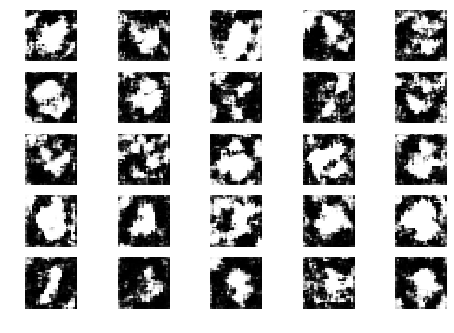

Epoch 0 Batch 51/187 [D loss: 0.069926, acc.: 96.88%] [G loss: 3.401733]
Epoch 0 Batch 52/187 [D loss: 0.071314, acc.: 100.00%] [G loss: 3.794627]
Epoch 0 Batch 53/187 [D loss: 0.046475, acc.: 100.00%] [G loss: 4.428695]
Epoch 0 Batch 54/187 [D loss: 0.099267, acc.: 96.88%] [G loss: 3.424358]
Epoch 0 Batch 55/187 [D loss: 0.018024, acc.: 100.00%] [G loss: 3.661994]
Epoch 0 Batch 56/187 [D loss: 0.049436, acc.: 100.00%] [G loss: 3.727014]
Epoch 0 Batch 57/187 [D loss: 0.014973, acc.: 100.00%] [G loss: 3.808439]
Epoch 0 Batch 58/187 [D loss: 0.052976, acc.: 100.00%] [G loss: 3.090155]
Epoch 0 Batch 59/187 [D loss: 0.051098, acc.: 100.00%] [G loss: 3.297899]
Epoch 0 Batch 60/187 [D loss: 0.027576, acc.: 100.00%] [G loss: 3.577417]
Epoch 0 Batch 61/187 [D loss: 0.039215, acc.: 100.00%] [G loss: 3.358767]
Epoch 0 Batch 62/187 [D loss: 0.085078, acc.: 100.00%] [G loss: 3.934150]
Epoch 0 Batch 63/187 [D loss: 0.139425, acc.: 93.75%] [G loss: 2.769580]
Epoch 0 Batch 64/187 [D loss: 0.074947, a

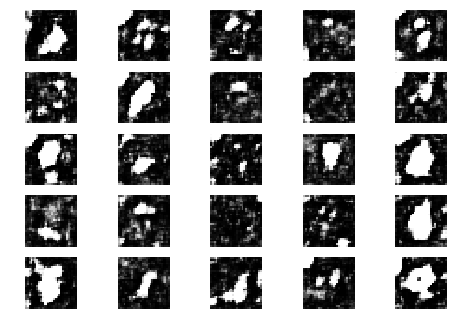

Epoch 0 Batch 101/187 [D loss: 0.051068, acc.: 100.00%] [G loss: 4.330462]
Epoch 0 Batch 102/187 [D loss: 0.088589, acc.: 100.00%] [G loss: 3.657056]
Epoch 0 Batch 103/187 [D loss: 0.039984, acc.: 100.00%] [G loss: 3.450900]
Epoch 0 Batch 104/187 [D loss: 0.073487, acc.: 100.00%] [G loss: 4.110746]
Epoch 0 Batch 105/187 [D loss: 0.591008, acc.: 68.75%] [G loss: 4.503282]
Epoch 0 Batch 106/187 [D loss: 0.092533, acc.: 100.00%] [G loss: 5.204613]
Epoch 0 Batch 107/187 [D loss: 0.058120, acc.: 100.00%] [G loss: 4.145702]
Epoch 0 Batch 108/187 [D loss: 0.220934, acc.: 90.62%] [G loss: 4.882879]
Epoch 0 Batch 109/187 [D loss: 0.336144, acc.: 81.25%] [G loss: 3.382551]
Epoch 0 Batch 110/187 [D loss: 0.072616, acc.: 100.00%] [G loss: 3.502298]
Epoch 0 Batch 111/187 [D loss: 0.141722, acc.: 96.88%] [G loss: 3.773405]
Epoch 0 Batch 112/187 [D loss: 0.111550, acc.: 96.88%] [G loss: 4.368007]
Epoch 0 Batch 113/187 [D loss: 0.496276, acc.: 87.50%] [G loss: 3.193122]
Epoch 0 Batch 114/187 [D loss: 

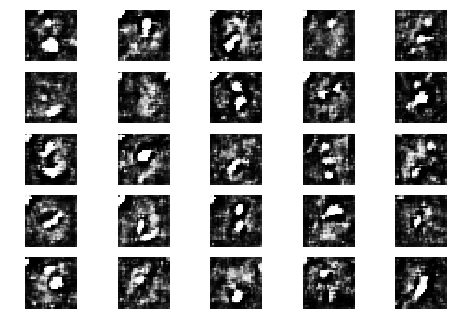

Epoch 0 Batch 151/187 [D loss: 0.692335, acc.: 59.38%] [G loss: 2.005962]
Epoch 0 Batch 152/187 [D loss: 0.882180, acc.: 53.12%] [G loss: 2.368459]
Epoch 0 Batch 153/187 [D loss: 0.669540, acc.: 71.88%] [G loss: 2.309860]
Epoch 0 Batch 154/187 [D loss: 0.778178, acc.: 56.25%] [G loss: 1.847189]
Epoch 0 Batch 155/187 [D loss: 0.894050, acc.: 56.25%] [G loss: 2.084577]
Epoch 0 Batch 156/187 [D loss: 0.404335, acc.: 84.38%] [G loss: 2.476575]
Epoch 0 Batch 157/187 [D loss: 0.696226, acc.: 65.62%] [G loss: 2.363657]
Epoch 0 Batch 158/187 [D loss: 0.756160, acc.: 59.38%] [G loss: 1.974515]
Epoch 0 Batch 159/187 [D loss: 0.709325, acc.: 62.50%] [G loss: 1.905299]
Epoch 0 Batch 160/187 [D loss: 0.845531, acc.: 62.50%] [G loss: 2.206229]
Epoch 0 Batch 161/187 [D loss: 0.738692, acc.: 65.62%] [G loss: 2.550047]
Epoch 0 Batch 162/187 [D loss: 0.754932, acc.: 59.38%] [G loss: 2.648883]
Epoch 0 Batch 163/187 [D loss: 0.503757, acc.: 68.75%] [G loss: 1.447562]
Epoch 0 Batch 164/187 [D loss: 0.74692

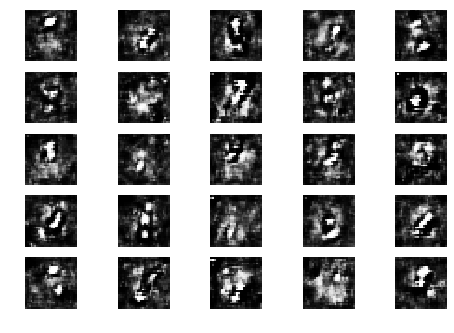

Epoch 1 Batch 1/187 [D loss: 0.896325, acc.: 50.00%] [G loss: 1.304272]
Epoch 1 Batch 2/187 [D loss: 1.015568, acc.: 53.12%] [G loss: 0.963704]
Epoch 1 Batch 3/187 [D loss: 0.792617, acc.: 53.12%] [G loss: 1.454198]
Epoch 1 Batch 4/187 [D loss: 0.712110, acc.: 62.50%] [G loss: 1.893768]
Epoch 1 Batch 5/187 [D loss: 0.484042, acc.: 78.12%] [G loss: 1.587366]
Epoch 1 Batch 6/187 [D loss: 0.930201, acc.: 46.88%] [G loss: 1.472919]
Epoch 1 Batch 7/187 [D loss: 0.686337, acc.: 59.38%] [G loss: 1.614402]
Epoch 1 Batch 8/187 [D loss: 0.844119, acc.: 46.88%] [G loss: 1.655647]
Epoch 1 Batch 9/187 [D loss: 0.939813, acc.: 43.75%] [G loss: 1.072876]
Epoch 1 Batch 10/187 [D loss: 1.013695, acc.: 43.75%] [G loss: 0.804735]
Epoch 1 Batch 11/187 [D loss: 0.808539, acc.: 59.38%] [G loss: 1.985932]
Epoch 1 Batch 12/187 [D loss: 0.880295, acc.: 56.25%] [G loss: 1.409584]
Epoch 1 Batch 13/187 [D loss: 0.901254, acc.: 56.25%] [G loss: 1.474307]
Epoch 1 Batch 14/187 [D loss: 0.622553, acc.: 71.88%] [G los

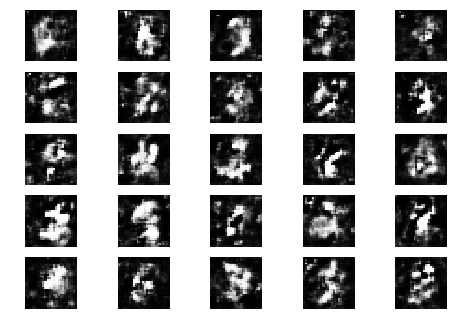

Epoch 1 Batch 51/187 [D loss: 0.500245, acc.: 75.00%] [G loss: 1.372777]
Epoch 1 Batch 52/187 [D loss: 1.225146, acc.: 28.12%] [G loss: 1.542751]
Epoch 1 Batch 53/187 [D loss: 0.591673, acc.: 75.00%] [G loss: 2.004288]
Epoch 1 Batch 54/187 [D loss: 0.898117, acc.: 53.12%] [G loss: 1.420435]
Epoch 1 Batch 55/187 [D loss: 0.577159, acc.: 71.88%] [G loss: 1.231135]
Epoch 1 Batch 56/187 [D loss: 0.930897, acc.: 37.50%] [G loss: 1.033830]
Epoch 1 Batch 57/187 [D loss: 0.542125, acc.: 78.12%] [G loss: 1.296957]
Epoch 1 Batch 58/187 [D loss: 0.621535, acc.: 68.75%] [G loss: 1.876262]
Epoch 1 Batch 59/187 [D loss: 0.956257, acc.: 56.25%] [G loss: 1.930176]
Epoch 1 Batch 60/187 [D loss: 0.740345, acc.: 53.12%] [G loss: 1.500982]
Epoch 1 Batch 61/187 [D loss: 0.636210, acc.: 68.75%] [G loss: 1.756250]
Epoch 1 Batch 62/187 [D loss: 0.547508, acc.: 75.00%] [G loss: 1.967091]
Epoch 1 Batch 63/187 [D loss: 0.771049, acc.: 53.12%] [G loss: 1.307537]
Epoch 1 Batch 64/187 [D loss: 1.098066, acc.: 40.62

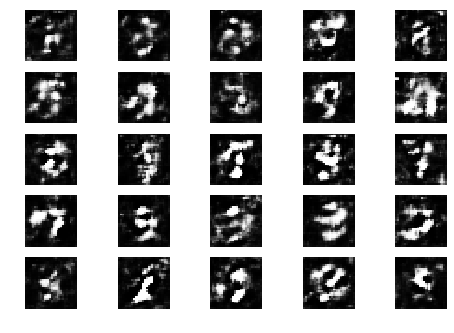

Epoch 1 Batch 101/187 [D loss: 0.593594, acc.: 65.62%] [G loss: 1.226706]
Epoch 1 Batch 102/187 [D loss: 0.799668, acc.: 59.38%] [G loss: 1.177275]
Epoch 1 Batch 103/187 [D loss: 0.746340, acc.: 62.50%] [G loss: 1.448093]
Epoch 1 Batch 104/187 [D loss: 0.832877, acc.: 46.88%] [G loss: 1.215647]
Epoch 1 Batch 105/187 [D loss: 0.698927, acc.: 59.38%] [G loss: 1.337594]
Epoch 1 Batch 106/187 [D loss: 0.813326, acc.: 50.00%] [G loss: 1.490229]
Epoch 1 Batch 107/187 [D loss: 0.982812, acc.: 50.00%] [G loss: 1.328983]
Epoch 1 Batch 108/187 [D loss: 0.868512, acc.: 43.75%] [G loss: 1.429414]
Epoch 1 Batch 109/187 [D loss: 0.773157, acc.: 56.25%] [G loss: 0.894481]
Epoch 1 Batch 110/187 [D loss: 0.483556, acc.: 81.25%] [G loss: 1.178041]
Epoch 1 Batch 111/187 [D loss: 0.945255, acc.: 50.00%] [G loss: 1.462174]
Epoch 1 Batch 112/187 [D loss: 0.694443, acc.: 62.50%] [G loss: 1.017909]
Epoch 1 Batch 113/187 [D loss: 0.621898, acc.: 68.75%] [G loss: 1.455343]
Epoch 1 Batch 114/187 [D loss: 0.54599

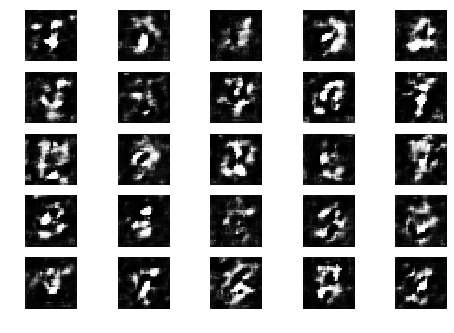

Epoch 1 Batch 151/187 [D loss: 0.860012, acc.: 46.88%] [G loss: 1.407078]
Epoch 1 Batch 152/187 [D loss: 0.702067, acc.: 59.38%] [G loss: 1.293054]
Epoch 1 Batch 153/187 [D loss: 0.839614, acc.: 40.62%] [G loss: 1.148184]
Epoch 1 Batch 154/187 [D loss: 1.095066, acc.: 31.25%] [G loss: 1.028485]
Epoch 1 Batch 155/187 [D loss: 0.837667, acc.: 46.88%] [G loss: 0.932533]
Epoch 1 Batch 156/187 [D loss: 0.746748, acc.: 46.88%] [G loss: 0.916141]
Epoch 1 Batch 157/187 [D loss: 0.607861, acc.: 62.50%] [G loss: 1.376004]
Epoch 1 Batch 158/187 [D loss: 0.679034, acc.: 59.38%] [G loss: 1.211634]
Epoch 1 Batch 159/187 [D loss: 0.734343, acc.: 53.12%] [G loss: 1.376032]
Epoch 1 Batch 160/187 [D loss: 0.523698, acc.: 75.00%] [G loss: 1.219241]
Epoch 1 Batch 161/187 [D loss: 0.725181, acc.: 50.00%] [G loss: 1.133607]
Epoch 1 Batch 162/187 [D loss: 0.821664, acc.: 59.38%] [G loss: 1.179379]
Epoch 1 Batch 163/187 [D loss: 0.656098, acc.: 59.38%] [G loss: 1.459801]
Epoch 1 Batch 164/187 [D loss: 0.61528

In [15]:
if __name__ == '__main__':
    main()

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [19]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Number of examples:  6000.0
Number of Batches:  187
Number of epochs:  1
Epoch 0 Batch 0/187 [D loss: 0.664766, acc.: 62.50%] [G loss: 0.964854]


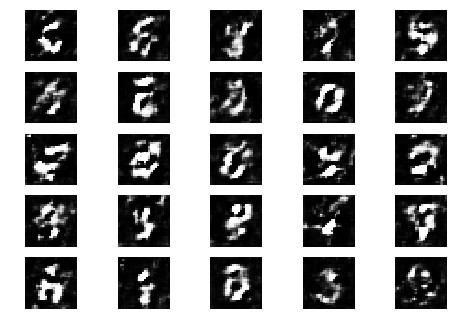

Epoch 0 Batch 1/187 [D loss: 0.640033, acc.: 68.75%] [G loss: 0.354021]
Epoch 0 Batch 2/187 [D loss: 0.507685, acc.: 75.00%] [G loss: 0.135035]
Epoch 0 Batch 3/187 [D loss: 0.883662, acc.: 43.75%] [G loss: 0.045793]
Epoch 0 Batch 4/187 [D loss: 0.823318, acc.: 53.12%] [G loss: 0.031750]
Epoch 0 Batch 5/187 [D loss: 0.627247, acc.: 62.50%] [G loss: 0.017549]
Epoch 0 Batch 6/187 [D loss: 0.810827, acc.: 40.62%] [G loss: 0.022509]
Epoch 0 Batch 7/187 [D loss: 0.786886, acc.: 43.75%] [G loss: 0.010463]
Epoch 0 Batch 8/187 [D loss: 0.643004, acc.: 65.62%] [G loss: 0.007797]
Epoch 0 Batch 9/187 [D loss: 0.642700, acc.: 65.62%] [G loss: 0.009272]
Epoch 0 Batch 10/187 [D loss: 0.702068, acc.: 62.50%] [G loss: 0.008512]
Epoch 0 Batch 11/187 [D loss: 0.597813, acc.: 71.88%] [G loss: 0.006515]
Epoch 0 Batch 12/187 [D loss: 0.642997, acc.: 65.62%] [G loss: 0.006133]
Epoch 0 Batch 13/187 [D loss: 0.972720, acc.: 37.50%] [G loss: 0.004513]
Epoch 0 Batch 14/187 [D loss: 0.684018, acc.: 53.12%] [G los

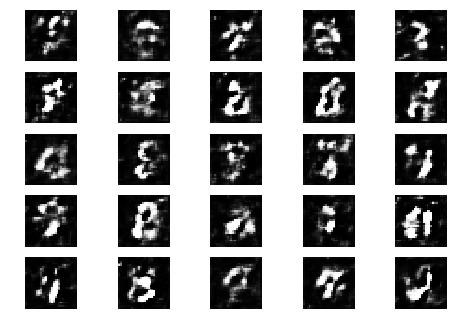

Epoch 0 Batch 51/187 [D loss: 0.724227, acc.: 53.12%] [G loss: 0.000866]
Epoch 0 Batch 52/187 [D loss: 0.845196, acc.: 59.38%] [G loss: 0.001099]
Epoch 0 Batch 53/187 [D loss: 0.522112, acc.: 65.62%] [G loss: 0.001155]
Epoch 0 Batch 54/187 [D loss: 0.804558, acc.: 56.25%] [G loss: 0.001527]
Epoch 0 Batch 55/187 [D loss: 0.572964, acc.: 68.75%] [G loss: 0.001213]
Epoch 0 Batch 56/187 [D loss: 0.614370, acc.: 71.88%] [G loss: 0.001235]
Epoch 0 Batch 57/187 [D loss: 0.640653, acc.: 71.88%] [G loss: 0.000743]
Epoch 0 Batch 58/187 [D loss: 0.650510, acc.: 68.75%] [G loss: 0.001414]
Epoch 0 Batch 59/187 [D loss: 0.457514, acc.: 84.38%] [G loss: 0.001416]
Epoch 0 Batch 60/187 [D loss: 0.518279, acc.: 81.25%] [G loss: 0.000830]
Epoch 0 Batch 61/187 [D loss: 0.856455, acc.: 56.25%] [G loss: 0.000707]
Epoch 0 Batch 62/187 [D loss: 0.394024, acc.: 84.38%] [G loss: 0.000876]
Epoch 0 Batch 63/187 [D loss: 0.702102, acc.: 62.50%] [G loss: 0.001012]
Epoch 0 Batch 64/187 [D loss: 0.653322, acc.: 68.75

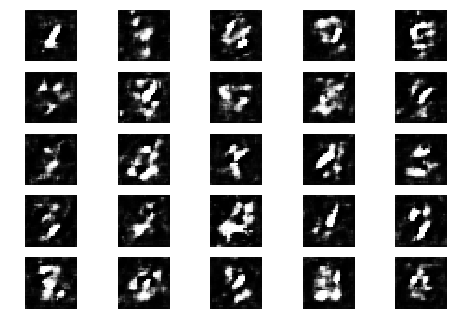

Epoch 0 Batch 101/187 [D loss: 0.815452, acc.: 50.00%] [G loss: 0.000773]
Epoch 0 Batch 102/187 [D loss: 0.500215, acc.: 68.75%] [G loss: 0.000287]
Epoch 0 Batch 103/187 [D loss: 0.423362, acc.: 84.38%] [G loss: 0.000373]
Epoch 0 Batch 104/187 [D loss: 0.554718, acc.: 81.25%] [G loss: 0.000498]
Epoch 0 Batch 105/187 [D loss: 0.448802, acc.: 78.12%] [G loss: 0.000648]
Epoch 0 Batch 106/187 [D loss: 0.547678, acc.: 71.88%] [G loss: 0.000381]
Epoch 0 Batch 107/187 [D loss: 0.618913, acc.: 65.62%] [G loss: 0.000728]
Epoch 0 Batch 108/187 [D loss: 0.590990, acc.: 59.38%] [G loss: 0.000288]
Epoch 0 Batch 109/187 [D loss: 0.599966, acc.: 71.88%] [G loss: 0.000547]
Epoch 0 Batch 110/187 [D loss: 0.517644, acc.: 75.00%] [G loss: 0.000458]
Epoch 0 Batch 111/187 [D loss: 0.522701, acc.: 71.88%] [G loss: 0.000692]
Epoch 0 Batch 112/187 [D loss: 0.556605, acc.: 68.75%] [G loss: 0.000298]
Epoch 0 Batch 113/187 [D loss: 0.696543, acc.: 62.50%] [G loss: 0.000253]
Epoch 0 Batch 114/187 [D loss: 0.53671

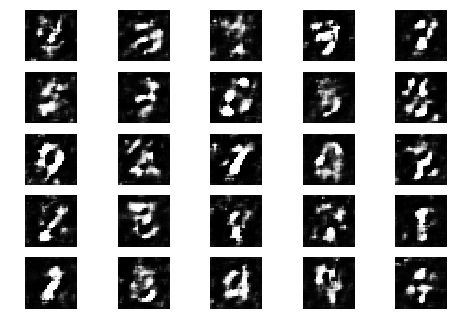

Epoch 0 Batch 151/187 [D loss: 0.493951, acc.: 81.25%] [G loss: 0.000173]
Epoch 0 Batch 152/187 [D loss: 0.550158, acc.: 68.75%] [G loss: 0.000218]
Epoch 0 Batch 153/187 [D loss: 0.447350, acc.: 75.00%] [G loss: 0.000187]
Epoch 0 Batch 154/187 [D loss: 0.773542, acc.: 56.25%] [G loss: 0.000251]
Epoch 0 Batch 155/187 [D loss: 0.279713, acc.: 96.88%] [G loss: 0.000232]
Epoch 0 Batch 156/187 [D loss: 0.569426, acc.: 62.50%] [G loss: 0.000155]
Epoch 0 Batch 157/187 [D loss: 0.447770, acc.: 71.88%] [G loss: 0.000243]
Epoch 0 Batch 158/187 [D loss: 0.408562, acc.: 81.25%] [G loss: 0.000195]
Epoch 0 Batch 159/187 [D loss: 0.473768, acc.: 75.00%] [G loss: 0.000295]
Epoch 0 Batch 160/187 [D loss: 0.547287, acc.: 68.75%] [G loss: 0.000169]
Epoch 0 Batch 161/187 [D loss: 0.497758, acc.: 78.12%] [G loss: 0.000172]
Epoch 0 Batch 162/187 [D loss: 0.390079, acc.: 84.38%] [G loss: 0.000176]
Epoch 0 Batch 163/187 [D loss: 0.495608, acc.: 78.12%] [G loss: 0.000368]
Epoch 0 Batch 164/187 [D loss: 0.35512

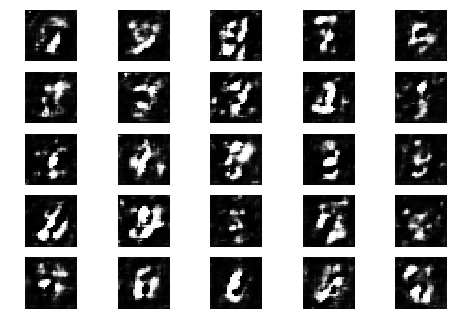

Epoch 1 Batch 1/187 [D loss: 0.499371, acc.: 75.00%] [G loss: 0.000095]
Epoch 1 Batch 2/187 [D loss: 0.381139, acc.: 84.38%] [G loss: 0.000161]
Epoch 1 Batch 3/187 [D loss: 0.330766, acc.: 84.38%] [G loss: 0.000169]
Epoch 1 Batch 4/187 [D loss: 0.526241, acc.: 75.00%] [G loss: 0.000169]
Epoch 1 Batch 5/187 [D loss: 0.280226, acc.: 84.38%] [G loss: 0.000170]
Epoch 1 Batch 6/187 [D loss: 0.317293, acc.: 93.75%] [G loss: 0.000127]
Epoch 1 Batch 7/187 [D loss: 0.509736, acc.: 75.00%] [G loss: 0.000191]
Epoch 1 Batch 8/187 [D loss: 0.493268, acc.: 75.00%] [G loss: 0.000237]
Epoch 1 Batch 9/187 [D loss: 0.381502, acc.: 75.00%] [G loss: 0.000252]
Epoch 1 Batch 10/187 [D loss: 0.280957, acc.: 90.62%] [G loss: 0.000082]
Epoch 1 Batch 11/187 [D loss: 0.489356, acc.: 68.75%] [G loss: 0.000142]
Epoch 1 Batch 12/187 [D loss: 0.452003, acc.: 75.00%] [G loss: 0.000146]
Epoch 1 Batch 13/187 [D loss: 0.280559, acc.: 87.50%] [G loss: 0.000304]
Epoch 1 Batch 14/187 [D loss: 0.385121, acc.: 81.25%] [G los

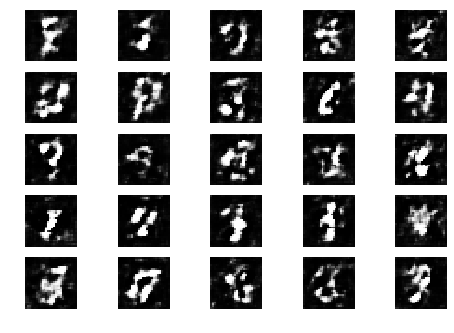

Epoch 1 Batch 51/187 [D loss: 0.490988, acc.: 78.12%] [G loss: 0.000148]
Epoch 1 Batch 52/187 [D loss: 0.195002, acc.: 96.88%] [G loss: 0.000051]
Epoch 1 Batch 53/187 [D loss: 0.596771, acc.: 75.00%] [G loss: 0.000106]
Epoch 1 Batch 54/187 [D loss: 0.253849, acc.: 96.88%] [G loss: 0.000074]
Epoch 1 Batch 55/187 [D loss: 0.323722, acc.: 93.75%] [G loss: 0.000123]
Epoch 1 Batch 56/187 [D loss: 0.273109, acc.: 90.62%] [G loss: 0.000111]
Epoch 1 Batch 57/187 [D loss: 0.308865, acc.: 90.62%] [G loss: 0.000121]
Epoch 1 Batch 58/187 [D loss: 0.399995, acc.: 81.25%] [G loss: 0.000156]
Epoch 1 Batch 59/187 [D loss: 0.187203, acc.: 96.88%] [G loss: 0.000213]
Epoch 1 Batch 60/187 [D loss: 0.272705, acc.: 90.62%] [G loss: 0.000071]
Epoch 1 Batch 61/187 [D loss: 0.117569, acc.: 96.88%] [G loss: 0.000108]
Epoch 1 Batch 62/187 [D loss: 0.116871, acc.: 96.88%] [G loss: 0.000063]
Epoch 1 Batch 63/187 [D loss: 0.360516, acc.: 90.62%] [G loss: 0.000080]
Epoch 1 Batch 64/187 [D loss: 0.209427, acc.: 96.88

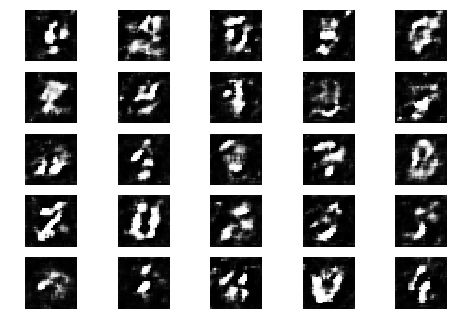

Epoch 1 Batch 101/187 [D loss: 0.332276, acc.: 84.38%] [G loss: 0.000066]
Epoch 1 Batch 102/187 [D loss: 0.514885, acc.: 65.62%] [G loss: 0.000085]
Epoch 1 Batch 103/187 [D loss: 0.347560, acc.: 87.50%] [G loss: 0.000082]
Epoch 1 Batch 104/187 [D loss: 0.439047, acc.: 75.00%] [G loss: 0.000038]
Epoch 1 Batch 105/187 [D loss: 0.263646, acc.: 93.75%] [G loss: 0.000072]
Epoch 1 Batch 106/187 [D loss: 0.321140, acc.: 84.38%] [G loss: 0.000086]
Epoch 1 Batch 107/187 [D loss: 0.066719, acc.: 100.00%] [G loss: 0.000106]
Epoch 1 Batch 108/187 [D loss: 0.344147, acc.: 87.50%] [G loss: 0.000063]
Epoch 1 Batch 109/187 [D loss: 0.353578, acc.: 84.38%] [G loss: 0.000062]
Epoch 1 Batch 110/187 [D loss: 0.150539, acc.: 96.88%] [G loss: 0.000101]
Epoch 1 Batch 111/187 [D loss: 0.278778, acc.: 87.50%] [G loss: 0.000076]
Epoch 1 Batch 112/187 [D loss: 0.426451, acc.: 87.50%] [G loss: 0.000062]
Epoch 1 Batch 113/187 [D loss: 0.226038, acc.: 93.75%] [G loss: 0.000125]
Epoch 1 Batch 114/187 [D loss: 0.2002

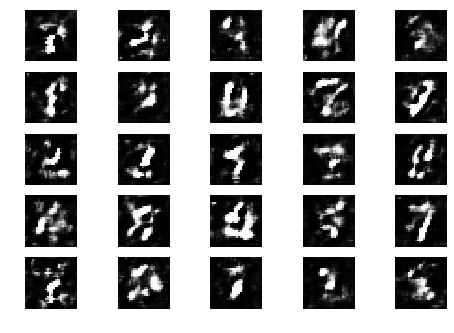

Epoch 1 Batch 151/187 [D loss: 0.187557, acc.: 96.88%] [G loss: 0.000063]
Epoch 1 Batch 152/187 [D loss: 0.566122, acc.: 78.12%] [G loss: 0.000047]
Epoch 1 Batch 153/187 [D loss: 0.104984, acc.: 100.00%] [G loss: 0.000078]
Epoch 1 Batch 154/187 [D loss: 0.186806, acc.: 93.75%] [G loss: 0.000059]
Epoch 1 Batch 155/187 [D loss: 0.157080, acc.: 100.00%] [G loss: 0.000035]
Epoch 1 Batch 156/187 [D loss: 0.210735, acc.: 93.75%] [G loss: 0.000071]
Epoch 1 Batch 157/187 [D loss: 0.177369, acc.: 96.88%] [G loss: 0.000086]
Epoch 1 Batch 158/187 [D loss: 0.063792, acc.: 100.00%] [G loss: 0.000046]
Epoch 1 Batch 159/187 [D loss: 0.138518, acc.: 100.00%] [G loss: 0.000050]
Epoch 1 Batch 160/187 [D loss: 0.242607, acc.: 90.62%] [G loss: 0.000180]
Epoch 1 Batch 161/187 [D loss: 0.207535, acc.: 93.75%] [G loss: 0.000046]
Epoch 1 Batch 162/187 [D loss: 0.257801, acc.: 93.75%] [G loss: 0.000054]
Epoch 1 Batch 163/187 [D loss: 0.209403, acc.: 93.75%] [G loss: 0.000067]
Epoch 1 Batch 164/187 [D loss: 0.3

In [20]:
train(generator1, discriminator1, combined1,
          epochs=1, batch_size=32, save_interval=1)

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)